In [1]:
import keras,os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL


In [83]:
img_dir = '/Users/padmaprabagaran/Desktop/Binary-Classification/dessert'

In [3]:
# parameters for loader
batch_size = 16
img_height = 300
img_width = 300

In [4]:
# Create trainning dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [5]:
# Create validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [6]:
# Check class names
class_names = train_data.class_names
print(class_names)

['chocolate cake', 'donuts']


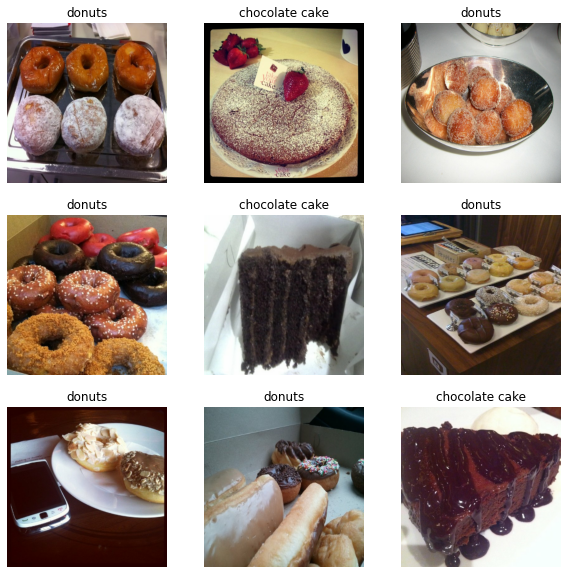

In [12]:
# visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")




In [14]:
# use random data augmenntation to make uo for small dataset
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

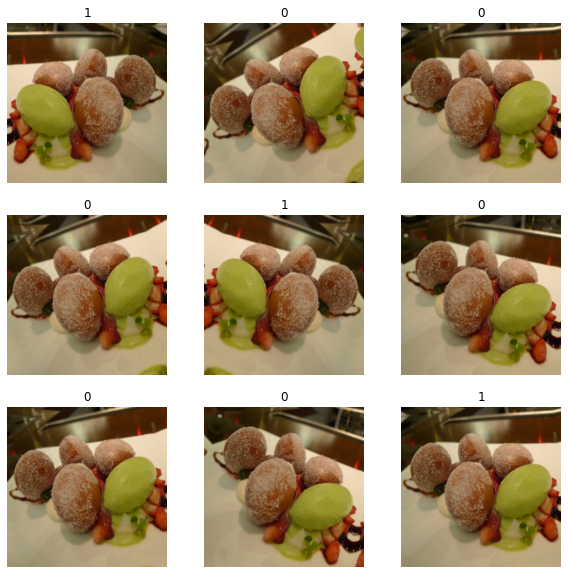

In [15]:
# visualize augmented data
for images, labels in train_data.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
# Build a model
base_model = keras.applications.Xception(
    weights='imagenet', # loading pre-trained weights on ImageNet
    input_shape=(300,300,3),
    include_top=False,
)

# Freeze base model
base_model.trainable = False

# Create a new model onn top 
inputs = keras.Input(shape=(300,300,3))
x = data_augmentation(inputs) # Applies reandom data augmentation

'''
# Normalize inputs 
Pre-trained Xception weights requires that input be normalized
from (0, 255) to a range (-1., +1.), the normalization layer
does the following, outputs = (inputs - mean) / sqrt(var)
'''
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

'''
The base model contains batchnorm layers. We want to keep them in inference mode
when we unfreeze the base model for fine-tuning, so we make sure that the
base_model is running in inference mode here.
'''
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

In [17]:
# Train the top layer
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
epochs = 20
model.fit(train_data, epochs=epochs, validation_data=val_data)

Epoch 1/20
100/100 [==============================] - 293s 3s/step - loss: 0.4580 - binary_accuracy: 0.7496 - val_loss: 0.1792 - val_binary_accuracy: 0.9475
Epoch 2/20
100/100 [==============================] - 367s 4s/step - loss: 0.2050 - binary_accuracy: 0.9162 - val_loss: 0.1371 - val_binary_accuracy: 0.9575
Epoch 3/20
100/100 [==============================] - 408s 4s/step - loss: 0.1633 - binary_accuracy: 0.9435 - val_loss: 0.1212 - val_binary_accuracy: 0.9500
Epoch 4/20
100/100 [==============================] - 393s 4s/step - loss: 0.1431 - binary_accuracy: 0.9445 - val_loss: 0.1115 - val_binary_accuracy: 0.9600
Epoch 5/20
100/100 [==============================] - 382s 4s/step - loss: 0.1244 - binary_accuracy: 0.9528 - val_loss: 0.1067 - val_binary_accuracy: 0.9600
Epoch 6/20
100/100 [==============================] - 391s 4s/step - loss: 0.1282 - binary_accuracy: 0.9459 - val_loss: 0.1025 - val_binary_accuracy: 0.9625
Epoch 7/20
100/100 [==============================] - 507s

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_data, epochs=epochs, validation_data=val_data)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

The predicted label is: chocolate cake


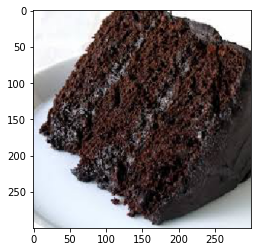

In [82]:
from keras.preprocessing import image

img_path = '/Users/padmaprabagaran/Desktop/predict/10.jpg'

img = image.load_img(img_path, target_size=(300,300))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img = np.array(img)
plt.imshow(img)

pred = model.predict(img_array)
score = pred[0]

if score < 0:
    print("The predicted label is: chocolate cake")
else:
    print("The predicted label is: donut")
